In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torch import nn
import torch.nn.functional as F

We will again use digits, this time with a MLP and then a CNN

In [3]:
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

In [4]:
training_data = MNIST('./mndist', train=True,  download=True, transform=ToTensor())
test_data = MNIST('./mndist', train=False,  download=True, transform=ToTensor())

In [5]:
from torch.utils.data import DataLoader

Hyperparameters

In [28]:
BATCH_SIZE = 256
LEARNING_RATE = 0.01
WORKERS = 10

In [29]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
test_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)

In [30]:
class MultiLayer(nn.Module):
    def __init__(self, shape=(28,28), num_classes=10):
        super().__init__()
        
        num_inputs = np.product(shape)
    
        self.layer1 = nn.Linear(num_inputs,50)
        self.layer2 = nn.Linear(50,100)
        self.layer3 = nn.Linear(100,num_classes)
        
    
    def forward(self, x):
        
        #Conv up here 
        
        x = x.reshape(x.shape[0], -1)
        h1 = self.layer1(x)
        h1 = F.relu(h1)
        h2 = self.layer2(h1)
        h2 = F.relu(h2)
        y = self.layer3(h2)
        
        return y  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [31]:
net = MultiLayer()

In [32]:
net

MultiLayer(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)

In [33]:
net = MultiLayer(shape=(28, 28), num_classes=10)

In [34]:
net

MultiLayer(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)

In [35]:
list(net.state_dict())

['layer1.weight',
 'layer1.bias',
 'layer2.weight',
 'layer2.bias',
 'layer3.weight',
 'layer3.bias']

## GPU (If Available)

In [36]:
import torch.cuda
torch.cuda.is_available()

True

In [37]:
if torch.cuda.is_available():
    def togpu(x):
        return x.cuda()
    def tocpu(x):
        return x.cpu()
else:
    def togpu(x):
        return x
    def tocpu(x):
        return x

In [38]:
net = togpu(net)

##  Setup loss & Optimizer __after__ net is put on GPU
The network must _already_ be on the GPU, otherwise the tensors that represent the parameters will be the CPU versions and _not_ the GPU version. See the call to `net.parameters()`

In [39]:
criterion = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)

# Training Loop

In [41]:
num_epochs = 2

In [42]:
import time

In [43]:
#!pip install tqdm

In [44]:
import tqdm

In [45]:
for epoch in tqdm.tnrange(num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    for i, data in tqdm.tqdm(enumerate(train_loader),
                             file=sys.stdout,
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data

        # Move inputs to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    tend = time.time()
    print("Epoch {: 4}   loss: {: 2.5f}  time: {}".format(epoch, 
                                                          running_loss / len(train_loader), 
                                                          tend-tstart))

Epoch    0   loss:  2.27376  time: 1.4061403274536133
Epoch    1   loss:  2.11441  time: 1.3852732181549072



In [46]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()), fontsize='small')
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))

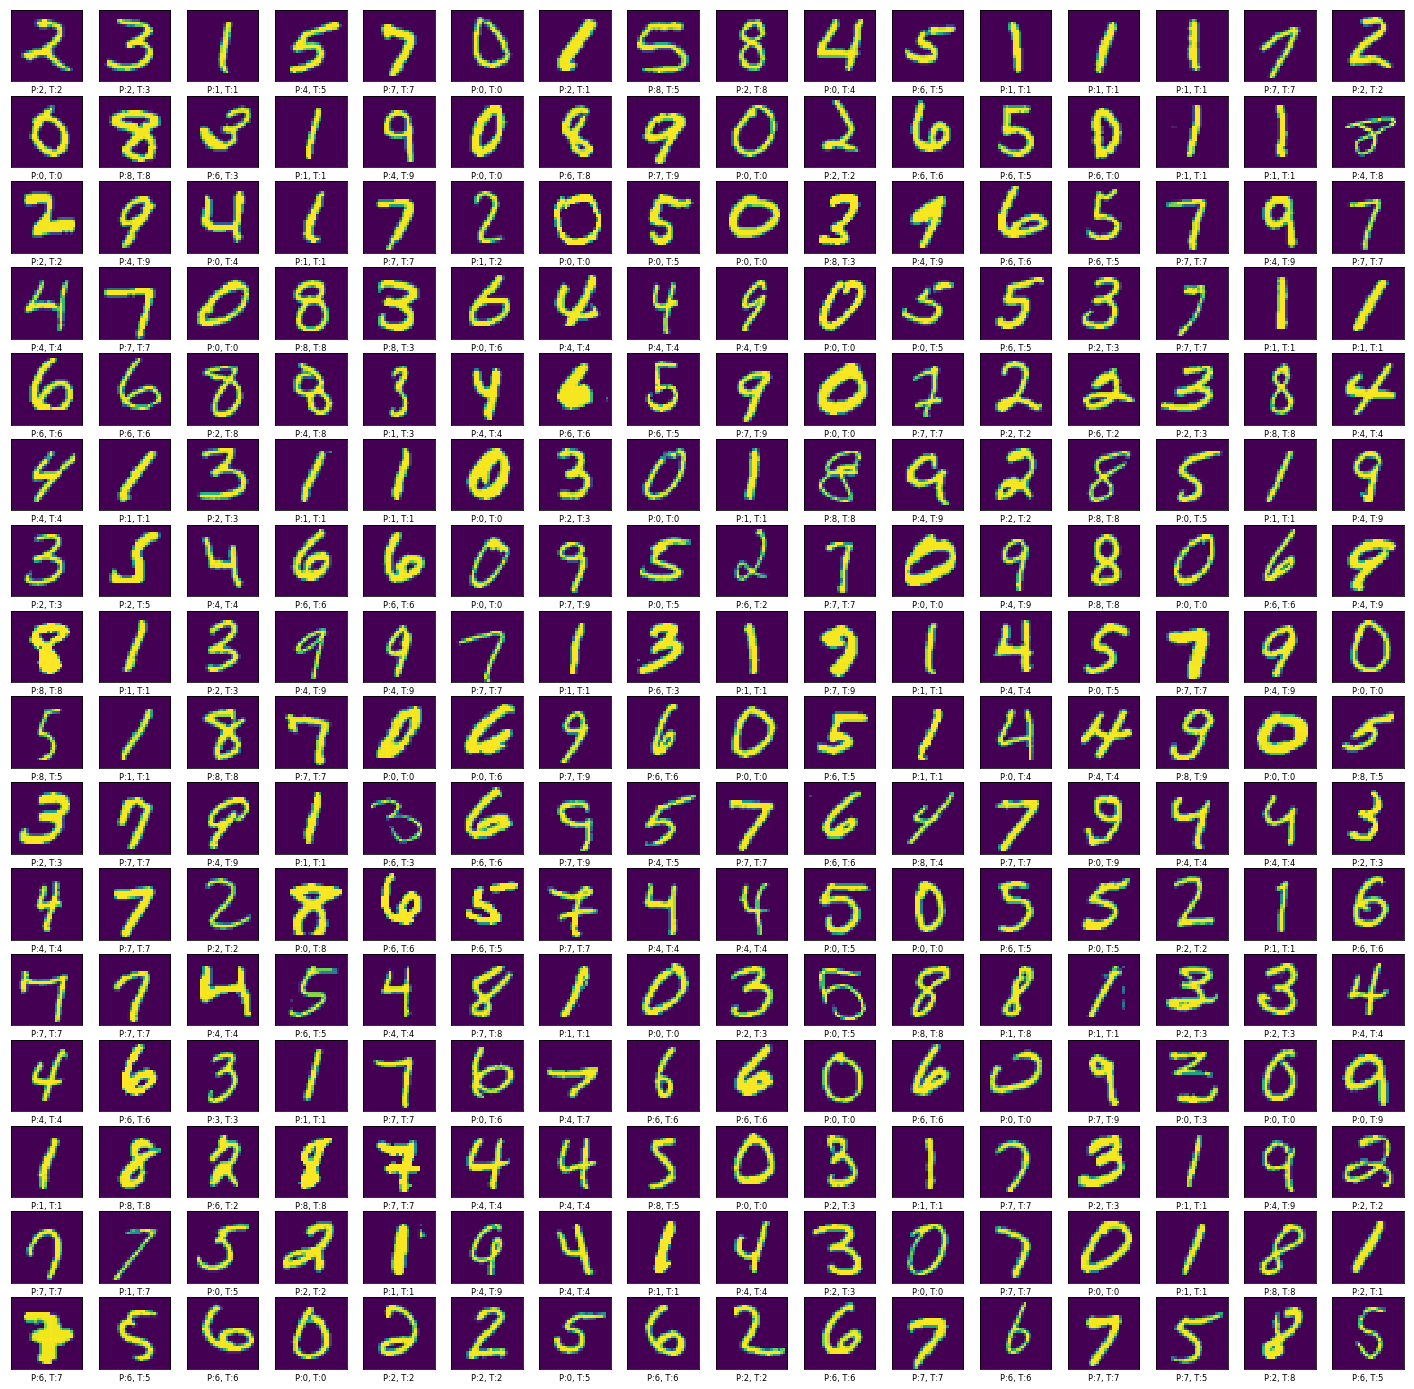

In [47]:
figsize(25,25)
eval_data, eval_target = iter(test_loader).next()
show_batch(eval_data, eval_target, 
           tocpu(net(togpu(eval_data))).detach().argmax(1))

In [48]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [49]:
import shutil

In [53]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = togpu(inputs), togpu(labels)
            outputs = net(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(test_loader)
    return eval_loss

In [56]:
compute_eval_loss(net, test_loader)

1.9314157546834743

In [67]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(net, test_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=net.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'multilayer-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('multilayer-checkpoint.pth.tar', 'multilayer-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch   29   loss:  0.25871  test-loss:  0.25683  time: 2.474040985107422
Epoch   30   loss:  0.25552  test-loss:  0.25338  time: 2.4431276321411133
Epoch   31   loss:  0.25228  test-loss:  0.25038  time: 2.8206570148468018
Epoch   32   loss:  0.24958  test-loss:  0.24761  time: 2.564162254333496
Epoch   33   loss:  0.24649  test-loss:  0.2447  time: 2.6427342891693115
Epoch   34   loss:  0.24415  test-loss:  0.24265  time: 2.5980658531188965
Epoch   35   loss:  0.24068  test-loss:  0.23836  time: 2.6322240829467773
Epoch   36   loss:  0.23825  test-loss:  0.23541  time: 2.763056993484497
Epoch   37   loss:  0.23574  test-loss:  0.23358  time: 2.4359705448150635
Epoch   38   loss:  0.23244  test-loss:  0.23052  time: 2.4557855129241943
Epoch   39   loss:  0.22974  test-loss:  0.22749  time: 2.5777242183685303
Epoch   40   loss:  0.22702  test-loss:  0.22578  time: 2.7790729999542236
Epoch   41   loss:  0.22466  test-loss:  0.22249  time: 2.7208499908447266
Epoch   42   loss:  0.22185  

# the GPU Utilization during training:
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.77                 Driver Version: 390.77                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   40C    P2    58W / 250W |    539MiB / 11178MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  GeForce GTX 108...  Off  | 00000000:0C:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   3  GeForce GTX 108...  Off  | 00000000:0E:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0     38289      C   ...mianjc/anaconda3/envs/CSE470/bin/python   529MiB |
+-----------------------------------------------------------------------------+
```

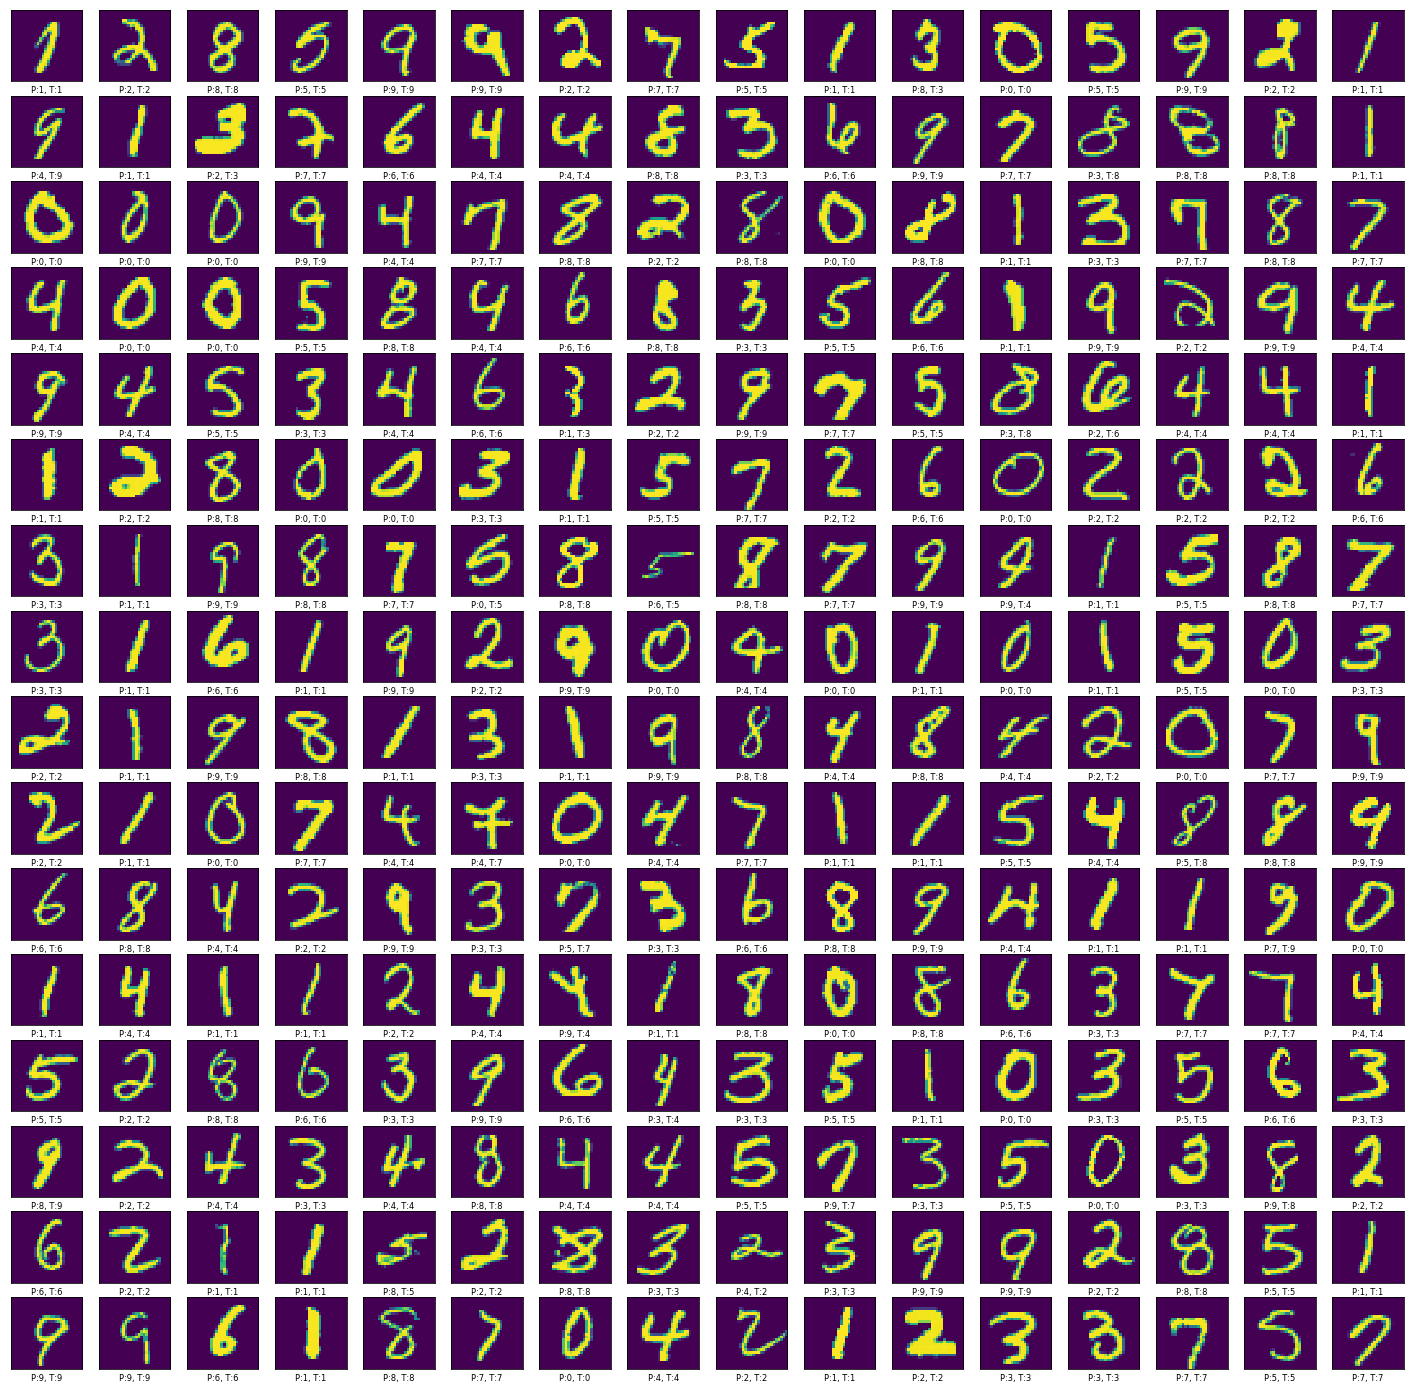

In [58]:
eval_data, eval_target = iter(test_loader).next()
show_batch(eval_data, eval_target, tocpu(net(togpu(eval_data))).detach().argmax(1))

In [68]:
predictions = np.zeros(len(test_data))
targets = np.zeros(len(test_data))

for i  in tqdm.tnrange(len(test_data)):
    x, t = test_data[i]
    p = tocpu(net(togpu(x[None,...]))).argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [69]:
from sklearn.metrics import classification_report

In [70]:
print(classification_report(targets, predictions))

             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       980
        1.0       0.97      0.98      0.98      1135
        2.0       0.94      0.93      0.94      1032
        3.0       0.92      0.95      0.93      1010
        4.0       0.95      0.95      0.95       982
        5.0       0.95      0.91      0.93       892
        6.0       0.95      0.96      0.95       958
        7.0       0.95      0.94      0.94      1028
        8.0       0.94      0.92      0.93       974
        9.0       0.94      0.92      0.93      1009

avg / total       0.95      0.95      0.94     10000



In [78]:
class SimpleCNN(nn.Module):
    def __init__(self, shape=(28,28), num_classes=10):
        super().__init__()
        
        #num_inputs = np.product(shape)
      
        self.layer1 = nn.Conv2d(1,64, (3,3), padding=1) # 28 --> Pool --> 14
        self.layer2 = nn.Conv2d(64,64, (3,3), padding=1) # 14 --> Pool --> 7
        
        self.layer3 = nn.Linear(7*7*64,num_classes)
        
    
    def forward(self, x):        
        # width = 28
        
        x = self.layer1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # width = 14
        
        x = self.layer2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # width = 7
        
        # Flatten
        x = x.reshape(-1, 7*7*64)  
        y = self.layer3(x)
        
        return y  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [81]:
net = togpu(SimpleCNN())
optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)
start_epoch = 0
num_epochs = 60

In [82]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(net, test_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=net.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    0   loss:  1.25684  test-loss:  0.50679  time: 3.6557741165161133
Epoch    1   loss:  0.42396  test-loss:  0.40328  time: 3.6120924949645996
Epoch    2   loss:  0.34120  test-loss:  0.31502  time: 3.699664831161499
Epoch    3   loss:  0.29800  test-loss:  0.34817  time: 3.7499048709869385
Epoch    4   loss:  0.26584  test-loss:  0.25422  time: 3.831041097640991
Epoch    5   loss:  0.24210  test-loss:  0.24035  time: 3.768806219100952
Epoch    6   loss:  0.21891  test-loss:  0.20531  time: 3.6111273765563965
Epoch    7   loss:  0.19988  test-loss:  0.19356  time: 3.620771646499634
Epoch    8   loss:  0.18458  test-loss:  0.18039  time: 3.882207155227661
Epoch    9   loss:  0.17084  test-loss:  0.17254  time: 3.6295087337493896
Epoch   10   loss:  0.15815  test-loss:  0.15324  time: 3.8168396949768066
Epoch   11   loss:  0.14768  test-loss:  0.14746  time: 3.6047399044036865
Epoch   12   loss:  0.13823  test-loss:  0.13731  time: 3.680673837661743
Epoch   13   loss:  0.13081  te

In [83]:
predictions = np.zeros(len(test_data))
targets = np.zeros(len(test_data))

for i  in tqdm.tnrange(len(test_data)):
    x, t = test_data[i]
    p = tocpu(net(togpu(x[None,...]))).argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [85]:
print(classification_report(targets, predictions, digits=3))

             precision    recall  f1-score   support

        0.0      0.981     0.993     0.987       980
        1.0      0.990     0.995     0.993      1135
        2.0      0.984     0.982     0.983      1032
        3.0      0.993     0.985     0.989      1010
        4.0      0.991     0.986     0.988       982
        5.0      0.987     0.983     0.985       892
        6.0      0.992     0.984     0.988       958
        7.0      0.981     0.985     0.983      1028
        8.0      0.973     0.982     0.977       974
        9.0      0.983     0.978     0.981      1009

avg / total      0.985     0.985     0.985     10000

